In [1]:
import warnings

# Suppress specific warning type
warnings.filterwarnings("ignore")

In [2]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannoor/data'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 42.6 MB

In [3]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import (
    TrainingArguments,
    Trainer,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    BitsAndBytesConfig,
)

import wandb
import evaluate

In [4]:
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

In [5]:

emotion_data = load_dataset('rxm210132/train_val')

Generating train split:   0%|          | 0/6179 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [6]:
emotion_data

DatasetDict({
    train: Dataset({
        features: ['texts', 'labels'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['texts', 'labels'],
        num_rows: 1545
    })
})

In [7]:
# emotion_data["train"]["labels"]

In [8]:
labels = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

##Load pre-trained Tokenizer

In [9]:
from huggingface_hub import notebook_login
notebook_login()

In [10]:
checkpoint = "Alibaba-NLP/gte-Qwen1.5-7B-instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True)

In [12]:
tokenized_dataset= emotion_data.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['texts']
)
# tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [13]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1545
    })
})

##Model Training

**compute_metrics function**

In [14]:
# accuracy_metric = evaluate.load('accuracy', 'multilabel')
# f1 = evaluate.load('f1','multilabel')

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     logits= logits[0]
#     # print(logits.shape)
#     preds = (logits > 0).astype(int)
#     accuracy = accuracy_metric.compute(predictions=preds, references=labels)
#     f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
#     f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
#     return {'f1_micro':f1_micro['f1'],
#             'f1_macro':f1_macro['f1'],
#             'accuracy':accuracy['accuracy'],
#             }

In [15]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits= logits[0]
    # print(logits.shape)
    preds = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy'],
            }

In [16]:
# Define the directory where model checkpoints will be saved
run_name = "emotions_gte_qlora_im"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=4,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,

    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-4,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=0,  # Number of warmup steps for the learning rate scheduler
    optim='adamw_torch',  # Optimizer,
    max_grad_norm = 1.0,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    # fp16=False,
    bf16=True
    # tf32= False
)


##Specify Model

In [17]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  llm_int8_skip_modules = ['score'],
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch.bfloat16
)

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config)

model = prepare_model_for_kbit_training(model)

config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config


config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/31.7k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/3.93G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Alibaba-NLP/gte-Qwen1.5-7B-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config

Qwen2Config {
  "_name_or_path": "Alibaba-NLP/gte-Qwen1.5-7B-instruct",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoModel": "Alibaba-NLP/gte-Qwen1.5-7B-instruct--modeling_qwen.Qwen2Model",
    "AutoModelForCausalLM": "Alibaba-NLP/gte-Qwen1.5-7B-instruct--modeling_qwen.Qwen2ForCausalLM",
    "AutoModelForSequenceClassification": "Alibaba-NLP/gte-Qwen1.5-7B-instruct--modeling_qwen.Qwen2ForSequenceClassification"
  },
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimis

In [20]:
model

Qwen2ForSequenceClassification(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 4096)
    (layers): ModuleList(
      (0-31): 32 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=True)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=True)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=True)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
   

In [21]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [22]:
# prompt: pass two observations from tokenized dataset to datacollatior

batch = [tokenized_dataset['train'][0], tokenized_dataset['train'][1]]
batch = data_collator(batch)
batch


{'labels': tensor([[0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]]), 'input_ids': tensor([[ 46339,    311,    633,   7037,    264,   2975,    315,    569,  53824,
          33555,    594,  40743,  26145,    369,    458,  14487,   2390,    429,
            358,    646,    944,   3061,    911,   1101,   3602,     13,    220,
            671,    309,  25304, 151643, 151643, 151643],
        [ 89916,    658,  33017,  18189,    569,  68556,   1098,    402,   6586,
            569,  12768,  35052,   3036,  32355,   1205,   2299,    279,   3245,
           3881,   7055,    304,    279,   4337,     11,    714,    773,  15713,
            498,   4588,    671,  58078,  30053,    220]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [23]:
input_ids = batch['input_ids']
input_ids

tensor([[ 46339,    311,    633,   7037,    264,   2975,    315,    569,  53824,
          33555,    594,  40743,  26145,    369,    458,  14487,   2390,    429,
            358,    646,    944,   3061,    911,   1101,   3602,     13,    220,
            671,    309,  25304, 151643, 151643, 151643],
        [ 89916,    658,  33017,  18189,    569,  68556,   1098,    402,   6586,
            569,  12768,  35052,   3036,  32355,   1205,   2299,    279,   3245,
           3881,   7055,    304,    279,   4337,     11,    714,    773,  15713,
            498,   4588,    671,  58078,  30053,    220]])

In [24]:
pad_token_id = 2

In [25]:
sequence_lengths = torch.eq(input_ids, pad_token_id).int().argmax(-1) - 1

In [26]:
sequence_lengths

tensor([-1, -1])

**QLORA Setup**

In [27]:
import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))
target_modules

['up_proj',
 'gate_proj',
 'down_proj',
 'score',
 'v_proj',
 'k_proj',
 'q_proj',
 'o_proj']

In [28]:
gte_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="lora_only",
    modules_to_save = ['score'],
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj']
)
gte_peft_model = get_peft_model(model, gte_peft_config )
gte_peft_model.print_trainable_parameters()

trainable params: 320,253,952 || all params: 7,418,900,480 || trainable%: 4.316730664649649


##Custom Trainer

In [29]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['labels'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['labels']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

# Calculate the pos_weight using the training set
pos_weights = calculate_pos_weights(emotion_data)


In [30]:
pos_weights

tensor([ 1.7018,  6.0216,  1.6576,  4.8403,  1.6657,  8.0734,  2.3256,  7.7274,
         2.4082, 17.9540, 19.0617])

In [31]:
pos_weights= torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [32]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [33]:
trainer = CustomTrainer(
    model=gte_peft_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [34]:
wandb.login()
%env WANDB_PROJECT = twitter_peft_gte

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=twitter_peft_gte


## Start Training

In [35]:
trainer.train()  # start training

wandb: Currently logged in as: rakshit-mathur38 (rm12345). Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,1.080500,0.621964,0.578597,0.484153,0.106796
40,0.572500,0.543809,0.670630,0.533446,0.170874
60,0.520800,0.523554,0.661429,0.555258,0.134628
80,0.520600,0.533368,0.664969,0.559504,0.161165
100,0.479800,0.510510,0.665723,0.598386,0.155340
120,0.379200,0.550669,0.671731,0.589775,0.183172
140,0.386100,0.539892,0.684928,0.582120,0.201294
160,0.380100,0.580765,0.668238,0.585219,0.176052
180,0.399600,0.520014,0.677227,0.590393,0.181877
200,0.330800,0.585491,0.683548,0.593906,0.214887


TrainOutput(global_step=384, training_loss=0.32812524245431024, metrics={'train_runtime': 2758.2223, 'train_samples_per_second': 8.961, 'train_steps_per_second': 0.139, 'total_flos': 3.962287850719642e+16, 'train_loss': 0.32812524245431024, 'epoch': 3.9741267787839587})

In [36]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [37]:
eval_results

{'eval_loss': 0.5103937983512878,
 'eval_f1_micro': 0.667377146240379,
 'eval_f1_macro': 0.5996345059626662,
 'eval_accuracy': 0.15663430420711974,
 'eval_runtime': 35.1901,
 'eval_samples_per_second': 43.904,
 'eval_steps_per_second': 5.513,
 'epoch': 3.9741267787839587}

In [38]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

**Check Confusion Matrix**

In [39]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["valid"])

In [40]:
valid_output.predictions.shape

(1545, 11)

In [41]:
predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

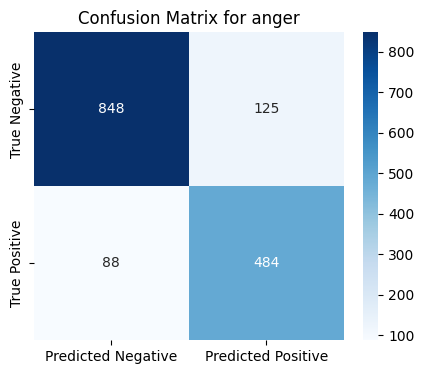

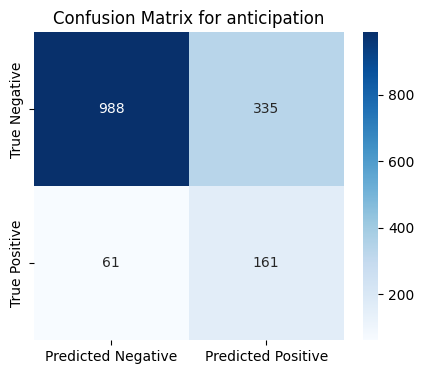

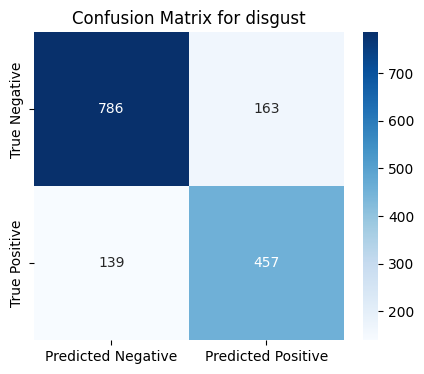

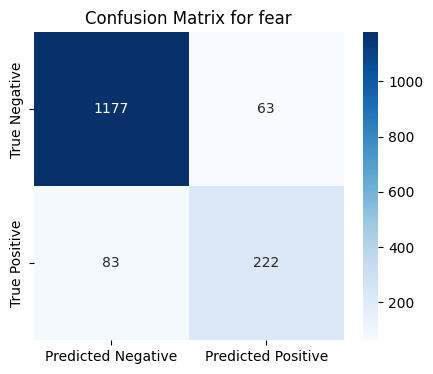

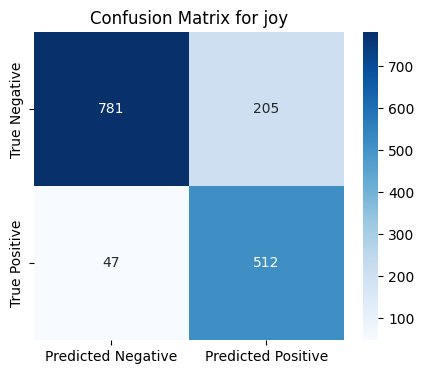

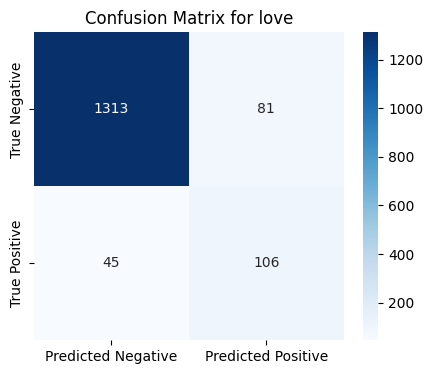

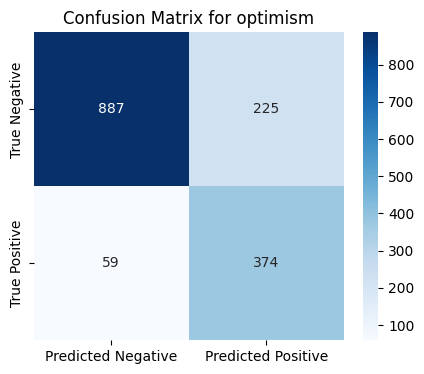

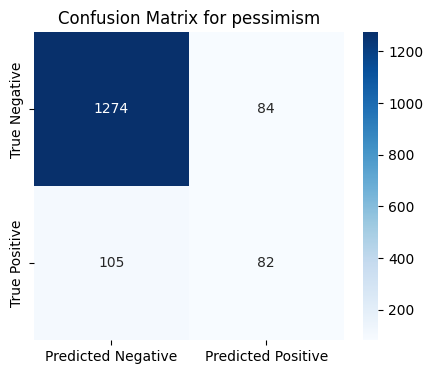

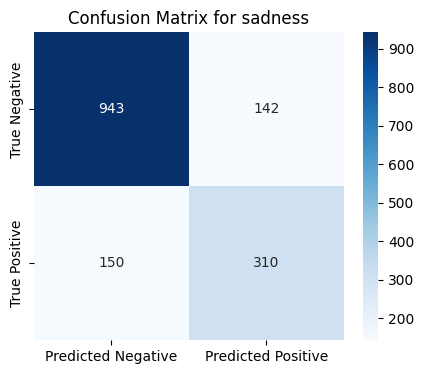

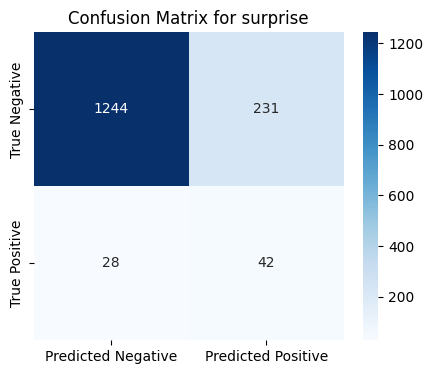

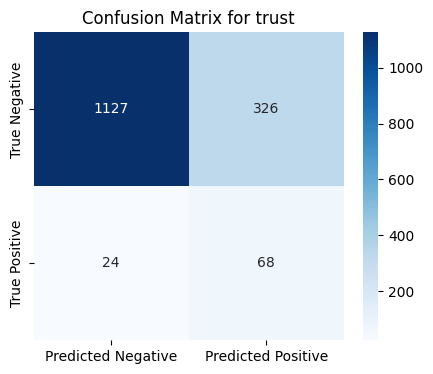

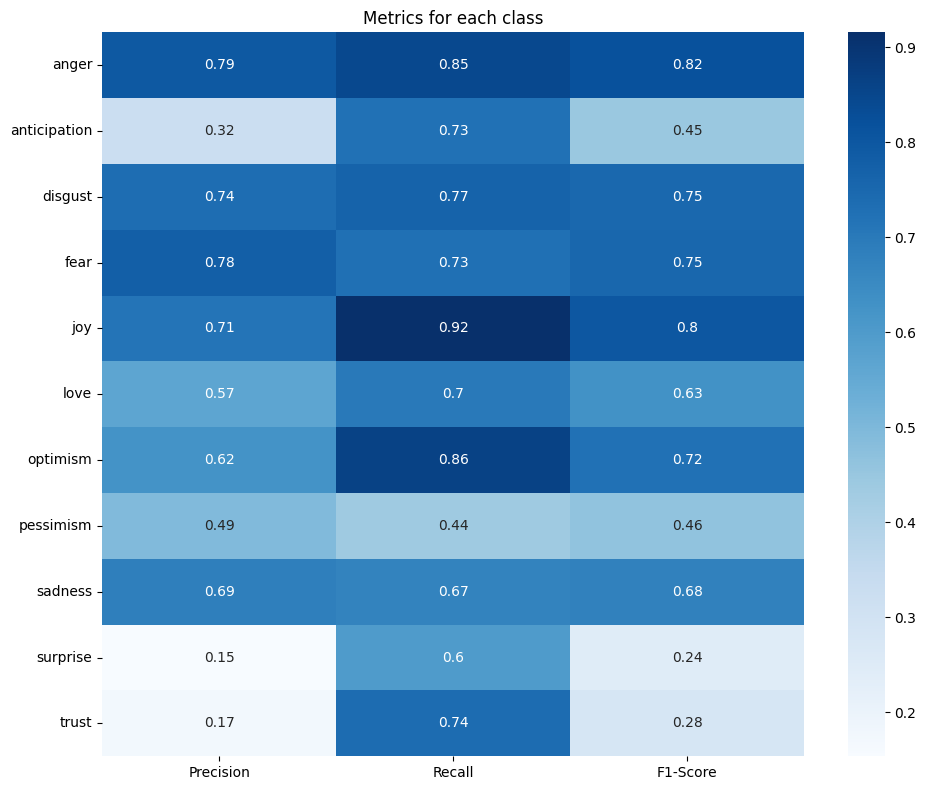

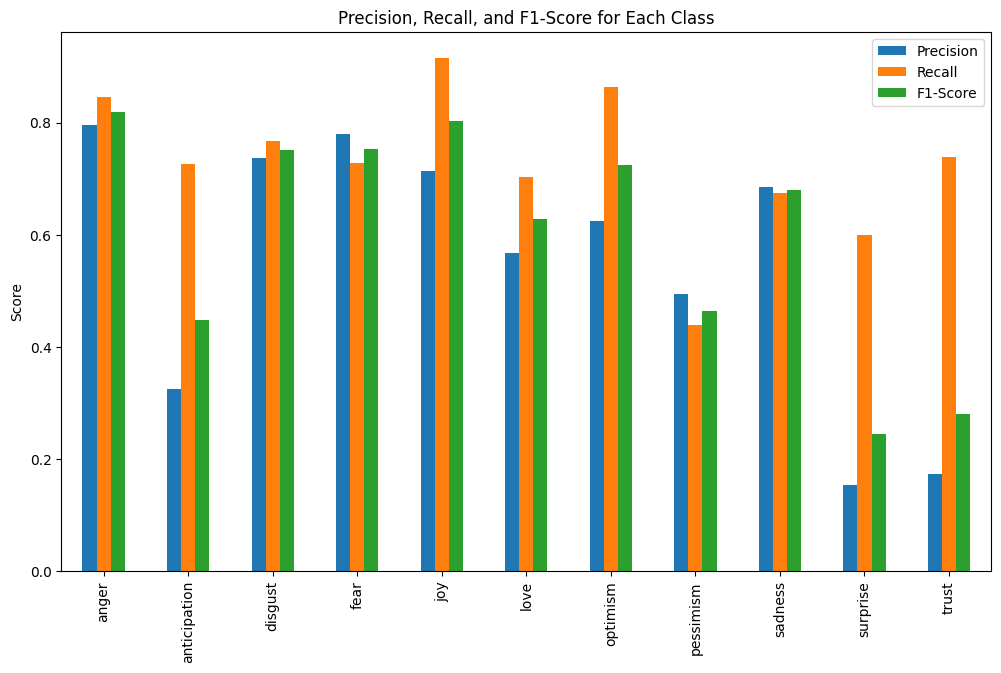

In [42]:
y_true = labels_valid
y_pred = predictions_valid
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()


In [43]:
gte_peft_model.push_to_hub("rxm210132/gemma_QLORA_gte_model_emotion_detection")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/1.28G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/rxm210132/gemma_QLORA_gte_model_emotion_detection/commit/a2d75a3032a717ee57a0e19653f39de50eb0f183', commit_message='Upload model', commit_description='', oid='a2d75a3032a717ee57a0e19653f39de50eb0f183', pr_url=None, pr_revision=None, pr_num=None)

In [44]:
gte_peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Qwen2ForSequenceClassification(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 4096)
        (layers): ModuleList(
          (0-31): 32 x Qwen2DecoderLayer(
            (self_attn): Qwen2SdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
       

In [46]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 100.


In [47]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/data/models/emotions_gte_qlora_im/checkpoint-100'

##Test Set Predictions

In [48]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer

bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  llm_int8_skip_modules = ['score'],
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch.bfloat16
)

peft_model_id = "rxm210132/gemma_QLORA_gte_model_emotion_detection"
config = PeftConfig.from_pretrained(peft_model_id)
config.base_model_name_or_path
base_model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path,
                                                                num_labels=11,
                                                                problem_type="multi_label_classification",
                                                                quantization_config=bnb_config)
base_model = prepare_model_for_kbit_training(base_model)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

adapter_config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Alibaba-NLP/gte-Qwen1.5-7B-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [49]:
testset = load_dataset("rxm210132/test")

Generating test split:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [51]:
test_set_tokenized = testset.map(tokenize_fn, batched=True)

test_set_tokenized = test_set_tokenized.remove_columns(
    ['texts']
)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [52]:
test_set_tokenized

DatasetDict({
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3259
    })
})

In [53]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=64,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name="emotions_gte_qlora_im"
)

In [54]:
trainer = CustomTrainer(
    model=gte_peft_model,
    args=training_args,
    eval_dataset=test_set_tokenized["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # Ensure no train_dataset is needed since do_train=False
)


In [55]:
test_results= trainer.evaluate()

In [56]:
test_results

{'eval_loss': 0.8395572900772095,
 'eval_f1_micro': 0.0,
 'eval_f1_macro': 0.0,
 'eval_accuracy': 0.0003068425897514575,
 'eval_runtime': 26.7848,
 'eval_samples_per_second': 121.673,
 'eval_steps_per_second': 1.904}

In [57]:
wandb.log({"test_accuracy": test_results["eval_accuracy"], "test_loss": test_results["eval_loss"],
"test_f1_micro": test_results["eval_f1_micro"], "test_f1_macro": test_results["eval_f1_macro"]})

**Confusion Matrix**

In [58]:
test_output = trainer.predict(test_set_tokenized['test'])

In [59]:
test_preds = (test_output.predictions > 0).astype(int)
test_labels = test_output.label_ids.astype(int)

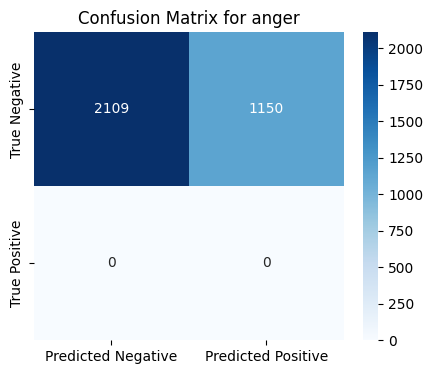

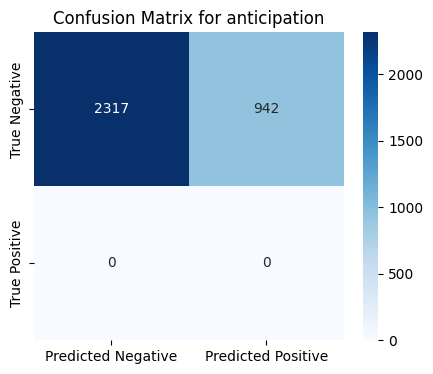

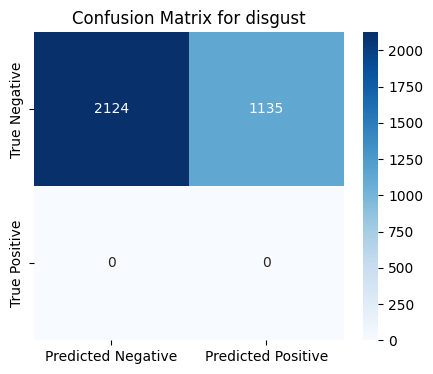

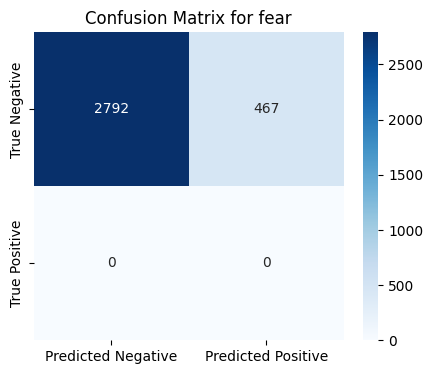

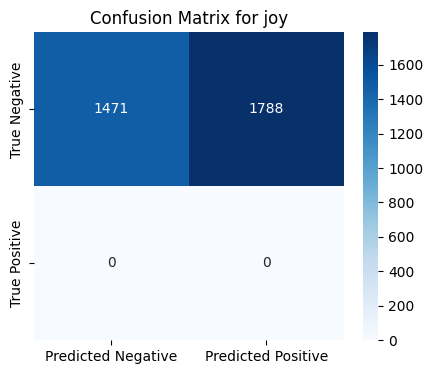

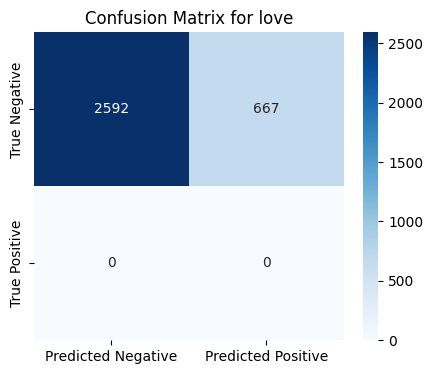

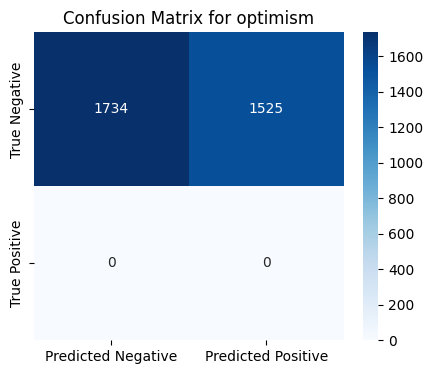

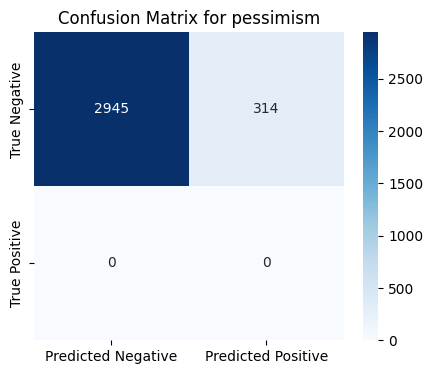

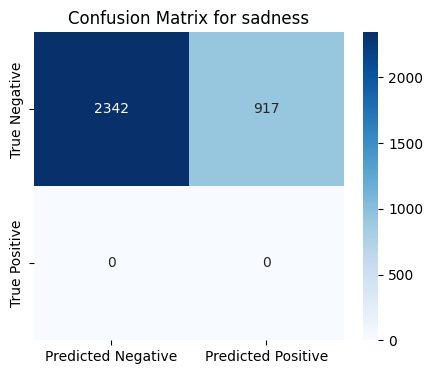

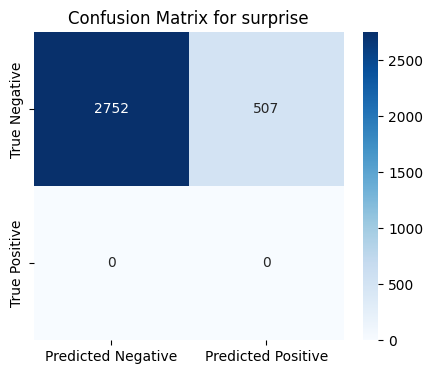

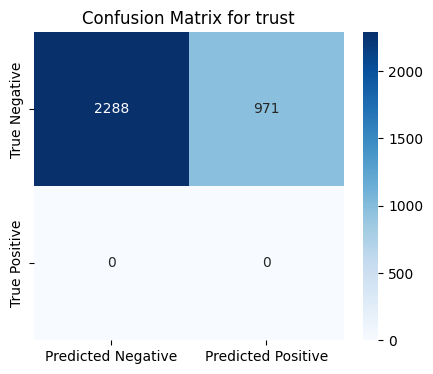

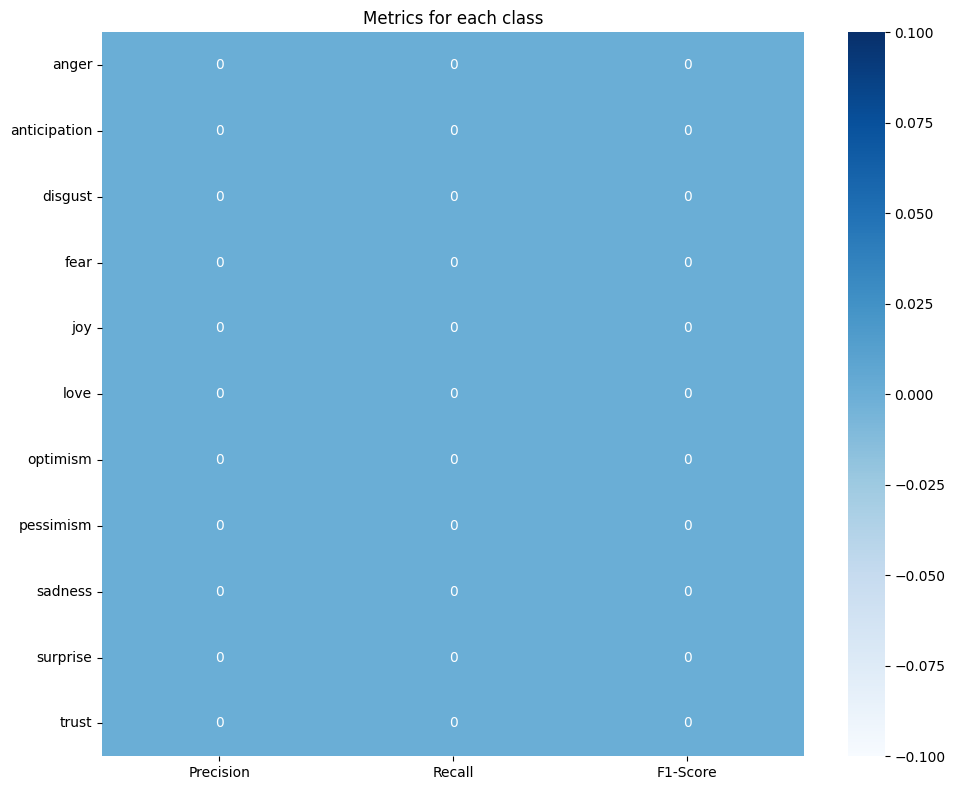

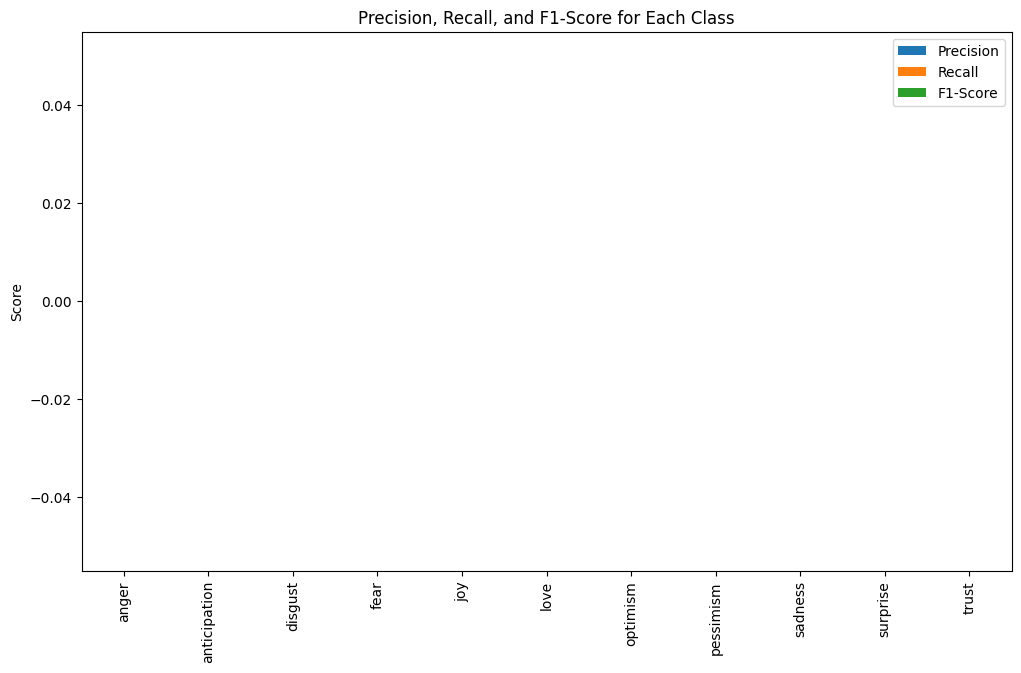

In [60]:
# Sample data
y_true = test_labels
y_pred = test_preds
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()

In [61]:
wandb.finish()

eval/accuracy,▁▄▂▄▄▅▆▅▅▇▅▇▆▅█▇█▇█▄
eval/f1_macro,▁▄▅▆█▇▇▇▇█▆▇▇▇▆▆▆▇▇█
eval/f1_micro,▁▇▆▇▇▇█▇▇█▇█▇▇███▇█▇
eval/loss,▃▁▁▁▁▂▁▂▁▂▃▃▃▃▆████▁
eval/runtime,▁▄▂▅▅▃▅▃▃▄▄▄▃▄▄▃▅▃▃█
eval/samples_per_second,█▅▇▄▄▆▄▆▆▅▅▅▆▅▅▆▄▅▆▁
eval/steps_per_second,█▅▇▄▄▆▄▆▆▅▅▅▆▅▅▆▄▆▆▁
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁


##Load Results

In [62]:
%cd /content/drive/MyDrive/data/datasets/HW 5

/content/drive/MyDrive/data/datasets/HW 5


In [63]:
# Assuming the file path is correct, and you have mounted your Google Drive
df_test = pd.read_csv("test.csv")

In [64]:
# Assuming 'test_preds' contains the predicted values (0 or 1) for each emotion
# Assuming 'class_names' contains the list of emotion class names

# Iterate over each emotion class name
for label in class_names:
    # Replace 'NONE' values with the predicted binary values from test_preds
    df_test[label] = test_preds[:, class_names.index(label)]

# Drop the 'Tweet' column
df_test.drop(columns=['Tweet'], inplace=True)

In [65]:
# Save the updated DataFrame to a new CSV file
#df_test.to_csv('predicted_emotions_test_gemma1.csv', index=False)

# Export to CSV
df_test.to_csv('/content/drive/MyDrive/predicted_emotions_test_gte_qlora.csv', index=False)

print("Predicted emotions saved to predicted_emotions_test_gte_qlora.csv")

Predicted emotions saved to predicted_emotions_test_gte_qlora.csv


##Model Inference

In [66]:
from transformers import pipeline

checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Alibaba-NLP/gte-Qwen1.5-7B-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


**Test the pipeline on a single example**

In [67]:
sample = testset['test']['texts'][0]
preds = custom_pipeline(sample)
preds

[{'label': 'LABEL_0', 'score': 0.9999983310699463}]

**Test the pipeline on a large dataset**

In [68]:
predictions = custom_pipeline(testset['test']['texts'], truncation=True)

In [69]:
predictions[0:10]

[{'label': 'LABEL_0', 'score': 0.9999983310699463},
 {'label': 'LABEL_0', 'score': 0.9999988079071045},
 {'label': 'LABEL_0', 'score': 0.9999901056289673},
 {'label': 'LABEL_0', 'score': 0.6659661531448364},
 {'label': 'LABEL_0', 'score': 0.9999980926513672},
 {'label': 'LABEL_0', 'score': 0.9982252717018127},
 {'label': 'LABEL_0', 'score': 0.9999778270721436},
 {'label': 'LABEL_0', 'score': 0.9999512434005737},
 {'label': 'LABEL_0', 'score': 0.9963036775588989},
 {'label': 'LABEL_0', 'score': 0.9963850975036621}]